<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/analyze_gluc_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install XlsxWriter
# !pip install pingouin
# !pip install CMH
# !pip install svgutils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import tifffile
import numpy as np
from google import colab
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl
import pandas as pd

In [3]:
def get_drobox_file(new_filename, link):
    !wget -o $new_filename $link
    return new_filename


In [4]:
def get_drobox_file(new_filename, link):
    !wget -O $new_filename $link
    return new_filename

link = 'https://www.dropbox.com/s/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx?dl=1'
new_filename = 'data.xlsx'
get_drobox_file(new_filename, link)
my_df_dict  = pd.read_excel('/content/data.xlsx',engine='openpyxl',header=[0,1,2,3],index_col=None,sheet_name=None) 

# Trim  blanks
for k,v in my_df_dict.items():
    v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
    for c in v.columns:
        if v[c].isnull().all():
            v=v.drop(c,axis=1)
    my_df_dict[k]=v
# display(v.head())

--2023-05-25 20:26:41--  https://www.dropbox.com/s/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx [following]
--2023-05-25 20:26:41--  https://www.dropbox.com/s/dl/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc29f7d901f66fa7f8f54d8e1c54.dl.dropboxusercontent.com/cd/0/get/B8ubgIfxnkgAlJdhxdMY3LJAzyjD-VjlJ4O987P6kXoXVmecc6-BFdvjXAMFBklDklZxr_q7d1_SapZzB1L3cSBrS7_aCU7wAlpg0HEyIlK7VI36FSkYgx5FWRh5h2EwGV9AwlQEhcCvXcIMfbiLv2HfCe0EZwqDLJAW6RFp7g2BT8p5NJ6DC91Ib9T6TfcJ-3s/file?dl=1# [following]
--2023-05-25 20:26:42--  https://uc29f7d901f66fa7f8f54d8e1c54.dl.dropboxusercontent.com/cd/0/get/B8ubgI

<ipython-input-4-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-aeca254e218d>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axi

In [5]:
my_df_dict = dict([(k,v) for k,v in my_df_dict.items() if '22' in k])

In [6]:
from scipy.signal import butter,filtfilt
import scipy

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):

    # b, a = butter(order, lpf, btype='lowpass')
    # trace_f = filtfilt(b, a, trace)
    trace_f = trace    
    good_ref = np.logical_not(np.isnan( trace_f[ref_inds]))
    ref_inds = ref_inds[good_ref]
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace/bleach_trace * (p[0][0]+p[0][2])
    return trace_corr, bleach_trace

def z_trans(y):
    return (y-np.nanmean(y))/np.nanstd(y)



In [7]:
def add_time(my_df_dict,basic_offset= -3.75, cam_rate =10):
    time_value_dict = {}
    for k,v in my_df_dict.items():
        
        df_time = v.copy()
        for c in v.columns:
            # print(k,c)
            freq = int(c[1].replace('Hz',""))
            'Base Pclamp Timing'
            if 'LFP' in c[3] or 'PopSpike' in c[3] or 'fEPSP slope' in c[2]:
                pulse_t_ind = np.arange(np.sum(v[c].notnull()))
                pulse_t = pulse_t_ind.astype('float') * 1/freq
                for i in pulse_t_ind:
                    df_time.at[i,c] = pulse_t[i]

            if 'Glucose' in c[2]:
                df_time[c] = pd.Series((np.arange(len(v[c])))/cam_rate)
                is_dip = z_trans( v[c] ) < -15                
                pulse_ind = np.where(is_dip)[0]
                pulse_ind = [i for i in pulse_ind if i <2000]
                y_t = df_time[c][pulse_ind]
                pulse_time = np.mean(y_t)
                df_time[c] = pd.Series((np.arange(len(v[c])))/10) - pulse_time + basic_offset
        time_value_dict[k] = {'values':v,'time':df_time}
    return time_value_dict

time_value_dict = add_time(my_df_dict)

May 22 S1 ('PMA', '100Hz', 'Glucose', 'Soma')
May 22 S1 ('PMA', '100Hz', 'Glucose', 'Dendrites')


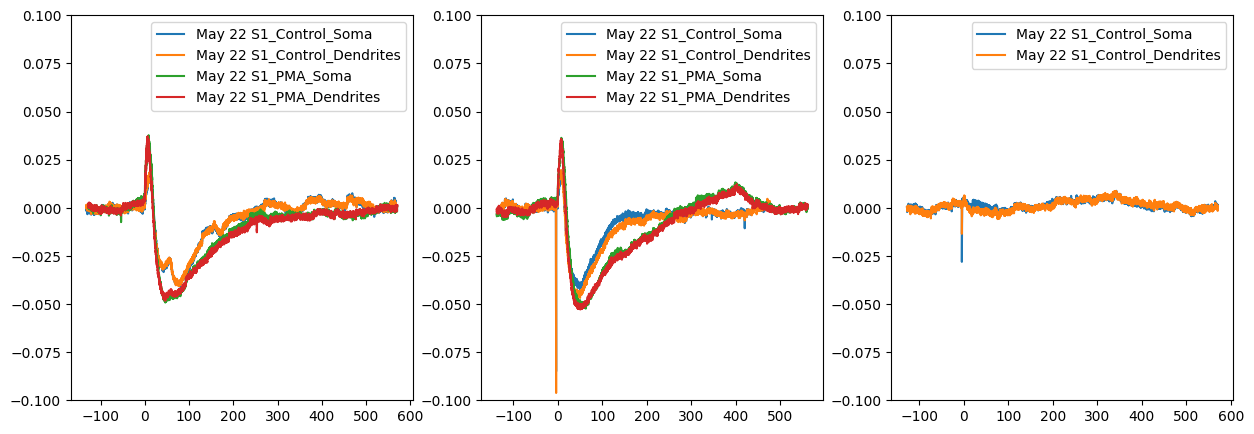

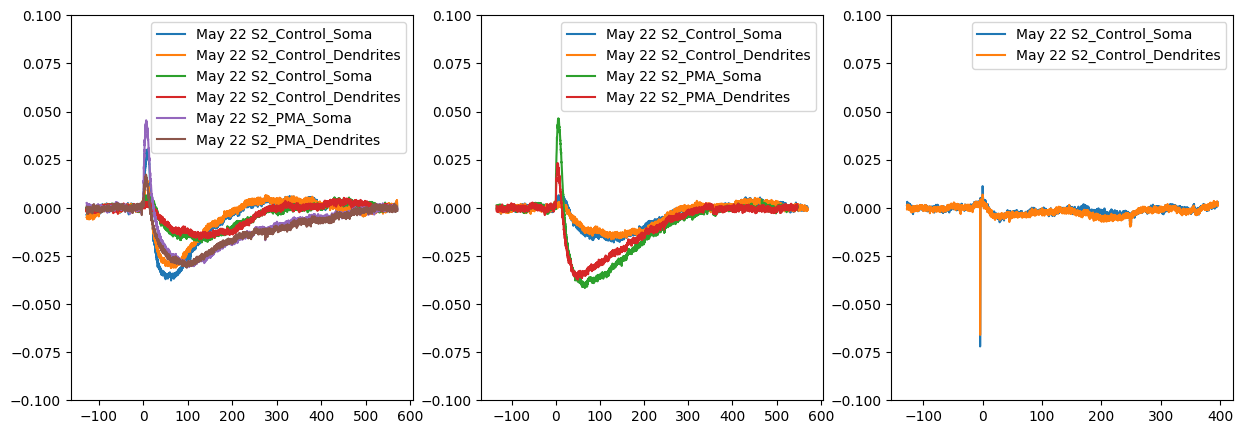

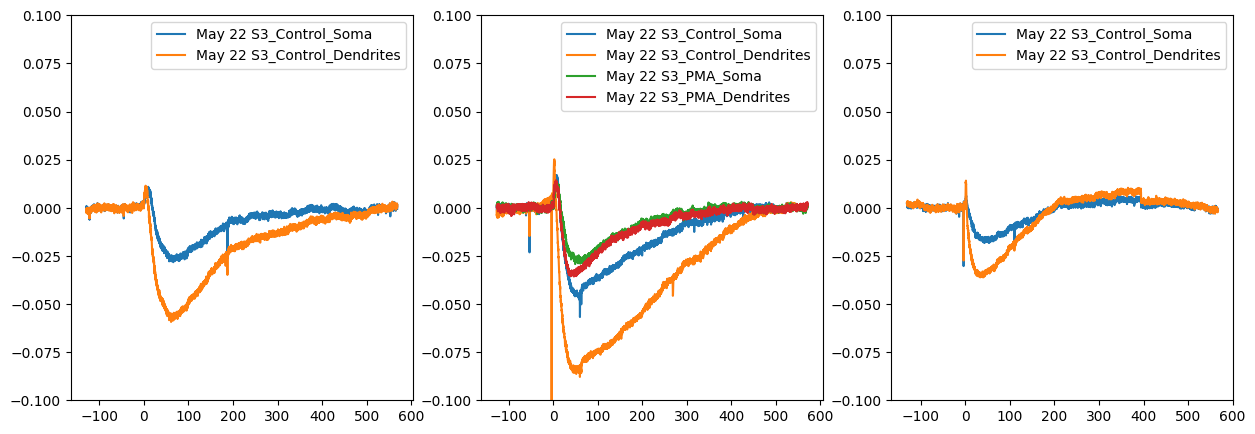

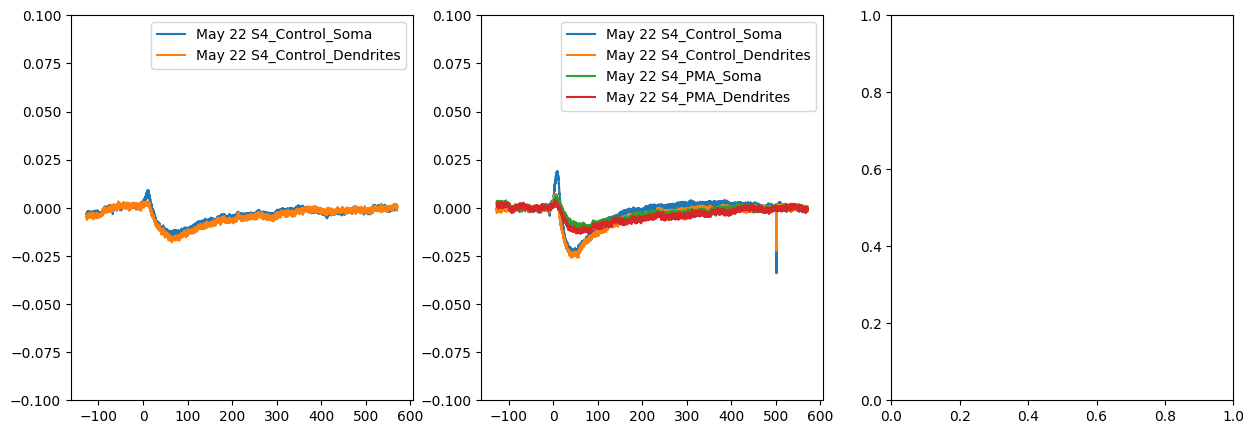

In [8]:

for k,v in time_value_dict.items():
    df_val = v['values'].copy()
    df_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    for c in df_val.columns:
        if 'Glucose' in c[2]:
            try:
                if '10Hz' in c[1]: axi=1
                if '5Hz' in c[1]: axi=0
                if '100Hz' in c[1]: axi=2
                trace = df_val[c]
                time = df_time[c]  

                '''bleach correction'''
                start_refs_bool = np.logical_and(time<-10,time>-100) #'keep inbetween'

                has_signal = abs(z_trans(trace))<5  # 'not out of range'
                has_sig_ind = np.arange(len(has_signal))[has_signal] #'convert to indicies'
                has_sig_ind = has_sig_ind[:-20] #'trim indicies'
                has_signal = np.zeros_like(has_signal) #'init new bool array'
                has_signal[has_sig_ind] = True #'flip good inicies'
                trim_time = time[has_signal]
                end_refs_bool = np.logical_and(time>np.max(trim_time)-50,time<np.max(trim_time)) #'keep last 50s'
                ref_inds_bool = np.logical_or( start_refs_bool, end_refs_bool) #'keep both windows'

                ref_inds=np.arange(len(ref_inds_bool))[ref_inds_bool]
                trace,bc = bleach_cor(trace,ref_inds)

                '''DF calc'''
                df_refs =  np.logical_and(time<-10,time>-100)
                f0 = np.mean(trace[df_refs])
                df_trace = (trace-f0)/f0
                label = k+'_'+c[0]+'_'+c[3]
                ax[axi].plot(time[has_signal], df_trace[has_signal],label=label)
                ax[axi].legend()
                # ax.set_xlim(-3,None)
                ax[axi].set_ylim(-.1,.1)
            except: print(k,c)
    
    
    plt.show()
# plt.legend()

In [10]:
def upsample(y_low,fs_low,fs_high,x_low=[],x_high=[],kind='quadratic'):
    len_low = len(y_low)
    up_ratio = fs_high/fs_low

    if len(x_low)==0: x_low=np.arange(len_low)
    if len(x_high)==0: x_high=np.arange(len_low*up_ratio)

    interpolator = scipy.interpolate.interp1d(x_low, y_low, kind=kind)
    y_high = interpolator(x_high)
    return y_high, x_high
    
    


In [9]:
'''
Bleach Correct all Traces,
Convert to dF/f
Z-Score
Upsample
Cross corr 

'''

'\nBleach Correct all Traces,\nConvert to dF/f\nZ-Score\nUpsample\nCross corr \n\n'